# REST API Homework - Michele Turco 813061

---

## 0) Import Libraries

This analysis requires libraries for data manipulation (pandas, numpy), visualization (matplotlib), API interactions (openaq, openmeteo_requests), and utilities for caching and file management. These dependencies enable efficient retrieval, processing, and exploration of air quality and meteorological data for Milan.

In [1]:
import os, json, time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import openmeteo_requests
import requests_cache
from retry_requests import retry
from openaq import OpenAQ
from keys import key_OpenAQ, key_OpenWeather

---

## 1) Data Retrieval

This section queries two REST APIs—OpenAQ for air quality measurements and Open-Meteo for meteorological data, covering Milan (45.46427°N, 9.18951°E) from January 1 to June 30, 2025. Both datasets are retrieved once via API, immediately exported to local CSV files, and subsequently reloaded for all downstream processing. This export-import workflow ensures reproducibility, avoids redundant API calls, and separates data acquisition from analysis—a fundamental best practice in data engineering.

### 1.1) OpenAQ Data Retrieval

The OpenAQ API provides comprehensive air quality measurements from multiple monitoring stations across Milan. Our spatial coverage strategy prioritizes all monitoring locations within a **5 km radius of central Milan** (45.46427°N, 9.18951°E), capturing **city-level air quality dynamics** rather than individual sensor noise. For each location, measurements from all available sensors are collected to ensure comprehensive spatial coverage. Our temporal resolution is set to **hourly aggregation**, though not all hours contain observations due to gaps arising from sensor availability, reporting schedules, and data transmission issues inherent to real-world monitoring networks. When multiple sensors measure the same pollutant in the same location and hour, values are **averaged** to reduce sensor-specific variability and produce a stable city-level signal suitable for integration with hourly meteorological data. The OpenAQ API enforces **rate limits** (60 calls/minute, 2,000 calls/hour), which the retrieval loop below respects while ensuring complete data coverage for the study period.

In [2]:
client = OpenAQ(api_key= key_OpenAQ)

data_air_quality = [] # to store results

# Variables to perform data retrieval
latitude = 45.46427
longitude = 9.18951
start_date = "2025-01-01"
end_date = "2025-06-30"

# Finding Loations in Milan
milan_locations = client.locations.list(coordinates=(latitude, longitude), radius=5000, limit=100, page=1)
print(f"Found {len(milan_locations.results)} locations")

# Iterate over stations and sensosr to fetch all data
for location in milan_locations.results:
    print(f"Processing Location: {location.name}...")
    for sensor in location.sensors:
        measures = client.measurements.list(sensors_id=sensor.id, datetime_from = start_date, datetime_to = end_date, rollup = "hourly")
        for measure in measures.results:
            data_air_quality.append({"location_id": location.id, 
                                     "location_name": location.name, 
                                     "locality": location.locality, 
                                     "sensor_id": sensor.id, 
                                     "sensor_name": sensor.name, 
                                     "pollutant": sensor.parameter.name, 
                                     "units": sensor.parameter.units,
                                     "datetime_from_utc": measure.period.datetime_from.utc, 
                                     "datetime_to_utc": measure.period.datetime_to.utc, 
                                     "value": measure.value})

# Storing the retrieved dat locally as a CSV file
output_file = "data_air_quality_milan.csv"
pd.DataFrame(data_air_quality).to_csv(f"data/{output_file}", index=False)
print(f"Data saved to {output_file}")

Found 7 locations
Processing Location: MILANO - SENATO...
Processing Location: MILANO - V.LE LIGURIA...
Processing Location: MILANO - VERZIERE...
Processing Location: MILANO PASCAL CITT� STUDI...
Processing Location: MILANO - V.LE MARCHE...
Processing Location: Porta Venezia...
Processing Location: Milano...
Data saved to data_air_quality_milan.csv


Store retrieved data locally as a CSV file for reproducibility and to avoid redundant API calls. All subsequent processing steps will reload data from this file, ensuring analysis remains fully reproducible even when the API is offline or rate-limited. This export-import workflow reflects best practices in data engineering by separating data acquisition from analysis and creating a permanent record of raw observations.

### 1.2) Open-Meteo Weather Data Retrieval

The **Open-Meteo API** provides hourly weather data for the same Milan coordinates and time period, ensuring **temporal and spatial alignment** with the air quality measurements. This section retrieves weather variables including **temperature**, **relative humidity**, **wind speed**, and **precipitation**—factors known to influence atmospheric dispersion, vertical mixing, and photochemical processes affecting air pollutant concentrations. Like the OpenAQ data, this dataset is retrieved once, exported locally, and reloaded for all subsequent processing steps. The API client incorporates **caching and retry mechanisms** to improve robustness and efficiency, handling transient network failures gracefully.

In [3]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Define parameters for weather data retrieval
weather_metrics = ["temperature_2m", "relative_humidity_2m", "wind_speed_10m", "precipitation"]

# Retrieve weather data from Open-Meteo API
print("Retrieving weather data from Open-Meteo API...")
responses = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive",
                 params={"latitude": latitude,
                         "longitude": longitude,
                         "start_date": start_date,
                         "end_date": end_date,
                         "hourly": weather_metrics
                                })

response = responses[0]

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

# Extracting each variable's data
hourly_data["temperature_2m_mean"] = hourly.Variables(0).ValuesAsNumpy()
hourly_data["precipitation"] = hourly.Variables(3).ValuesAsNumpy()
hourly_data["wind_speed_10m"] = hourly.Variables(2).ValuesAsNumpy()
hourly_data["relative_humidity_2m"] = hourly.Variables(1).ValuesAsNumpy()

# Creating DataFrame from hourly data
df_hourly_meteo = pd.DataFrame(data = hourly_data)

# Storing the retrieved data locally as a CSV file
output_file_meteo = "data_weather_milan.csv"
pd.DataFrame(df_hourly_meteo).to_csv(f"data/{output_file_meteo}", index=False)
print(f"Weather data saved to {output_file_meteo}")

Retrieving weather data from Open-Meteo API...
Weather data saved to data_weather_milan.csv


---

## 2) Data Cleaning and Integration

Raw API data requires substantial preprocessing before analysis can proceed. This section transforms UTC timestamps to local Milan time, aggregates sensor readings, filters for relevant pollutants, handles missing values, and merges air quality with weather data on a common hourly timeline. Each preprocessing step is explicitly justified to ensure methodological transparency and reproducibility, establishing a solid foundation for all subsequent exploratory and statistical analyses.

### 2.1) Import Data from Local Storage

Although the data was just retrieved and exported in Section 1, it is now reloaded from disk. This workflow mirrors real-world data pipelines where acquisition and analysis are **decoupled**, ensuring that accidental modification of in-memory objects during exploration does not corrupt the raw data source. Furthermore, this approach demonstrates that the entire analysis can be fully reproduced by anyone with access to the CSV files, without needing API credentials, dealing with rate limits, or waiting for data retrieval.

In [4]:
# Transform weather hourly data into DataFrame
data_weather_hourly = pd.read_csv("data/data_weather_milan.csv")
data_air_quality_hourly = pd.read_csv("data/data_air_quality_milan.csv")

### 2.2) Cleaning Air Quality Data

Air quality data from OpenAQ arrives in **UTC timezone** and requires multiple preprocessing steps before it can be merged with meteorological data. First, timestamps are converted from UTC to **Europe/Rome timezone** (UTC+1 or UTC+2 depending on daylight saving time), aligning air quality observations with local meteorological conditions and **human activity patterns** (e.g., morning and evening traffic peaks that drive NO₂ concentrations). Second, multiple sensors at different locations reporting the same pollutant in the same hour are **averaged** to produce a single city-level measurement per hour per pollutant, reducing spatial noise and ensuring compatibility with hourly weather data. Third, only **primary regulatory pollutants** (PM2.5, O₃, NO₂, CO, PM10) with well-established health impacts and sufficient measurement coverage are retained; redundant variables (e.g., temperature from air quality sensors) are discarded. Finally, rows with more than two **missing pollutant values** are removed to balance data retention with quality—observations with excessive missingness provide little analytical value and can distort subsequent imputation or modeling steps.

In [5]:
# Converting datetime_from and datetime_to in utc format
if "datetime_from_utc" in data_air_quality_hourly.columns and "datetime_to_utc" in data_air_quality_hourly.columns:
    data_air_quality_hourly["datetime_from_utc"] = pd.to_datetime(data_air_quality_hourly["datetime_from_utc"], utc=True)
    data_air_quality_hourly["datetime_to_utc"] = pd.to_datetime(data_air_quality_hourly["datetime_to_utc"], utc=True)
    data_air_quality_hourly["datetime"] = data_air_quality_hourly["datetime_from_utc"].dt.tz_convert("Europe/Rome")
    data_air_quality_hourly["date"] = data_air_quality_hourly["datetime"].dt.date

# Drop datetime_from and datetime_to columns
if "datetime_from_utc" in data_air_quality_hourly.columns and "datetime_to_utc" in data_air_quality_hourly.columns:
    data_air_quality_hourly = data_air_quality_hourly.drop(columns=["datetime_from_utc", "datetime_to_utc"])
else:
    print("Columns already dropped")

# Grouping data to get final result for each hour and pollutant
df__data_quality_pollutant = (data_air_quality_hourly.groupby(["datetime", "pollutant"], as_index=False).agg(mean_value=("value", "mean"), n_sensors=("sensor_id", "nunique")))

# Pivoting data to have pollutants as columns
df_air_quality = (df__data_quality_pollutant.pivot(index="datetime", columns="pollutant", values="mean_value").reset_index())

# Keep only relevant pollutants
relevant_pollutants = ["pm25", "o3", "no2", "co", "pm10"]
columns_to_keep = ["datetime"] + [pollutant for pollutant in relevant_pollutants if pollutant in df_air_quality.columns]
df_air_quality = df_air_quality[columns_to_keep]

# Drop rows with more than 2 missing values
df_air_quality = df_air_quality.dropna(thresh=df_air_quality.shape[1] - 2)

### 2.3) Cleaning Weather Data

Weather data from Open-Meteo is delivered in UTC timezone and requires timezone conversion to align with air quality observations in local Milan time. This synchronization is critical for understanding causal relationships. For instance, morning temperature changes should be matched to morning pollutant concentrations observed at the same local time, not at some arbitrary UTC offset. Additionally, the generic 'date' column is renamed to 'datetime' for consistency with the air quality dataset, facilitating the subsequent merge operation and reducing potential for column name mismatches or errors.

In [ ]:
# Converting date column in weather data to datetime with timezone
data_weather_hourly["date"] = pd.to_datetime(data_weather_hourly["date"], utc=True).dt.tz_convert("Europe/Rome")

# Rename date column for consistency
data_weather_hourly.rename(columns={'date': 'datetime'}, inplace=True)

### 2.4) Merging Datasets

The air quality and weather datasets are merged on the 'datetime' column using an inner join, ensuring that only hours with observations from both datasets are retained. This creates a complete bivariate dataset suitable for regression modeling and avoids the complications of imputing missing values across datasets. The inner join does discard hours where only one dataset has observations; given the irregular temporal coverage in OpenAQ data, this may reduce sample size. However, retaining mismatched timestamps would introduce systematic missing values that could bias subsequent analysis. The merged dataset is exported to a permanent CSV file, creating a stable reference for all downstream work and ensuring reproducibility without re-executing the merge.

In [7]:
# Merge air quality and weather data on the aligned datetime column
df_weather_air_quality = pd.merge(df_air_quality, data_weather_hourly, on="datetime", how="inner")

# Saving the merged dataset locally as a CSV file
output_file_merged = "data_weather_air_quality_milan.csv"
pd.DataFrame(df_weather_air_quality).to_csv(f"data/{output_file_merged}", index=False)
print(f"Merged data saved to {output_file_merged}")

print("\n--- Overview of the Merged Dataset ---")

# Showing the shape of the merged dataset
print(f"The dataset contains {df_weather_air_quality.shape[0]} rows and {df_weather_air_quality.shape[1]} columns.")


# Show the the type and missing values of each column in the merged dataset
for column in df_weather_air_quality.columns:
    print(f"-{column}: Type: {df_weather_air_quality[column].dtype}, Missing Values: {df_weather_air_quality[column].isna().sum()}")

Merged data saved to data_weather_air_quality_milan.csv

--- Overview of the Merged Dataset ---
The dataset contains 1040 rows and 10 columns.
-datetime: Type: datetime64[ns, Europe/Rome], Missing Values: 0
-pm25: Type: float64, Missing Values: 33
-o3: Type: float64, Missing Values: 39
-no2: Type: float64, Missing Values: 5
-co: Type: float64, Missing Values: 0
-pm10: Type: float64, Missing Values: 4
-temperature_2m_mean: Type: float64, Missing Values: 0
-precipitation: Type: float64, Missing Values: 0
-wind_speed_10m: Type: float64, Missing Values: 0
-relative_humidity_2m: Type: float64, Missing Values: 0


### 2.5) Missing Values Handling

Forward-fill followed by backward-fill imputation is applied to remaining missing values in the merged dataset. This method assumes temporal continuity: if a pollutant concentration is missing at hour t, it is likely similar to the value at t−1 or t+1. For time-series data with high temporal autocorrelation (typical of environmental variables), carry-forward imputation preserves realistic variability better than mean imputation or complete deletion. Backward-fill handles edge cases at the start of the series where forward-fill cannot be applied. While this approach cannot recover abrupt changes or events during missing periods, given the small dataset size and the need to maximize usable observations, imputation is preferable to listwise deletion, which would substantially reduce statistical power for subsequent modeling.

In [8]:
# Display missing values for each column in the merged dataset
missing_values = df_weather_air_quality.isnull().sum()
print("Missing values in each column of the merged dataset:")
print(missing_values)

# Inputing missing values using forward fill and backward fill
df_weather_air_quality.bfill(inplace=True)
df_weather_air_quality.ffill(inplace=True)

# Display the number of missing values after imputation
missing_values_after = df_weather_air_quality.isnull().sum()
print("Total missing values after imputation:")
print(missing_values_after)

Missing values in each column of the merged dataset:
datetime                 0
pm25                    33
o3                      39
no2                      5
co                       0
pm10                     4
temperature_2m_mean      0
precipitation            0
wind_speed_10m           0
relative_humidity_2m     0
dtype: int64
Total missing values after imputation:
datetime                0
pm25                    0
o3                      0
no2                     0
co                      0
pm10                    0
temperature_2m_mean     0
precipitation           0
wind_speed_10m          0
relative_humidity_2m    0
dtype: int64


### 2.6) Renaming Columns for Clarity

Column names are standardized to include units and proper chemical notation (e.g., 'PM2.5 (µg/m³)', 'NO₂ (µg/m³)') for improved interpretability in visualizations and model outputs. This step is cosmetic but essential for clear communication of results to stakeholders and ensuring self-documenting code that reduces the risk of unit-related errors or misinterpretation.

In [9]:
# Rename columns for better readability (capitalization and spacing)
df_weather_air_quality.rename(columns={
    "temperature_2m_mean": "Temperature (°C)",
    "relative_humidity_2m": "Relative Humidity (%)",
    "wind_speed_10m": "Wind Speed (m/s)",
    "precipitation": "Precipitation (mm)",
    "pm25": "PM2.5 (µg/m³)",
    "o3": "O₃ (µg/m³)",
    "no2": "NO₂ (µg/m³)",
    "co": "CO (µg/m³)",
    "so2": "SO₂ (µg/m³)"
}, inplace=True)

### 2.7) Final Data Verification

Data types are verified to ensure datetime columns are properly parsed and numeric columns remain numeric. This verification step prevents silent errors in downstream operations such as time-series indexing, mathematical operations, or statistical modeling that would fail or produce incorrect results if data types are incorrect.

In [10]:
# Displaying data types of each column
data_types = df_weather_air_quality.dtypes
print("Data types of each column in the merged dataset:")
print(data_types)

Data types of each column in the merged dataset:
datetime                 datetime64[ns, Europe/Rome]
PM2.5 (µg/m³)                                float64
O₃ (µg/m³)                                   float64
NO₂ (µg/m³)                                  float64
CO (µg/m³)                                   float64
pm10                                         float64
Temperature (°C)                             float64
Precipitation (mm)                           float64
Wind Speed (m/s)                             float64
Relative Humidity (%)                        float64
dtype: object


---

## 3) Exploratory Data Analysis

Exploratory analysis reveals distributional characteristics, correlation structures, and temporal dynamics that inform modeling choices and interpretation within the context of air quality science. Each visualization is motivated by specific analytical questions about the behavior of pollutants, meteorological drivers, and potential relationships relevant to air quality forecasting and policy development.

### 3.1) Numerical Features Distributions

Histograms and summary statistics reveal whether variables are normally distributed, skewed, or multimodal—information critical for selecting appropriate statistical methods and identifying potential outliers or data quality issues. Descriptive statistics (mean, median, standard deviation, min, max) provide a quantitative summary of central tendency and variability, forming the foundation for understanding the typical range and variation of each variable. **Box plots** are employed to detect outliers, which in the context of air quality data may represent genuine pollution episodes rather than errors.

In [11]:
# Select numeric columns
numeric_cols = df_weather_air_quality.select_dtypes(include="number").columns

# Summary statistics
summary_stats = df_weather_air_quality[numeric_cols].describe().T
summary_stats["missing_count"] = df_weather_air_quality[numeric_cols].isna().sum()
summary_stats["missing_pct"] = (
    summary_stats["missing_count"] / len(df_weather_air_quality) * 100
).round(2)

summary_stats

,count,mean,std,min,25%,50%,75%,max,missing_count,missing_pct
PM2.5 (µg/m³),1040.0,19.487497,17.475694,1.040000,7.830000,14.000000,26.916667,146.300000,0,0.0
O₃ (µg/m³),1040.0,46.183645,29.727865,1.186500,17.387500,49.475000,69.550000,115.000000,0,0.0
NO₂ (µg/m³),1040.0,30.980760,16.332052,5.160000,18.385000,27.240000,41.115000,92.740000,0,0.0
CO (µg/m³),1040.0,577.113082,234.359669,199.000000,436.500000,516.500000,639.625000,2032.000000,0,0.0
pm10,1040.0,27.168668,21.206982,1.160000,12.203750,22.427500,34.556250,164.900000,0,0.0
Temperature (°C),1040.0,11.472740,5.027824,-0.300000,7.750000,12.100000,14.950000,23.050000,0,0.0
Precipitation (mm),1040.0,0.244327,1.012599,0.000000,0.000000,0.000000,0.000000,15.300000,0,0.0
Wind Speed (m/s),1040.0,6.656643,4.945740,0.000000,3.381893,5.595943,8.313680,32.125336,0,0.0
Relative Humidity (%),1040.0,75.115363,18.381609,21.667381,61.788227,79.656405,90.219877,100.000000,0,0.0


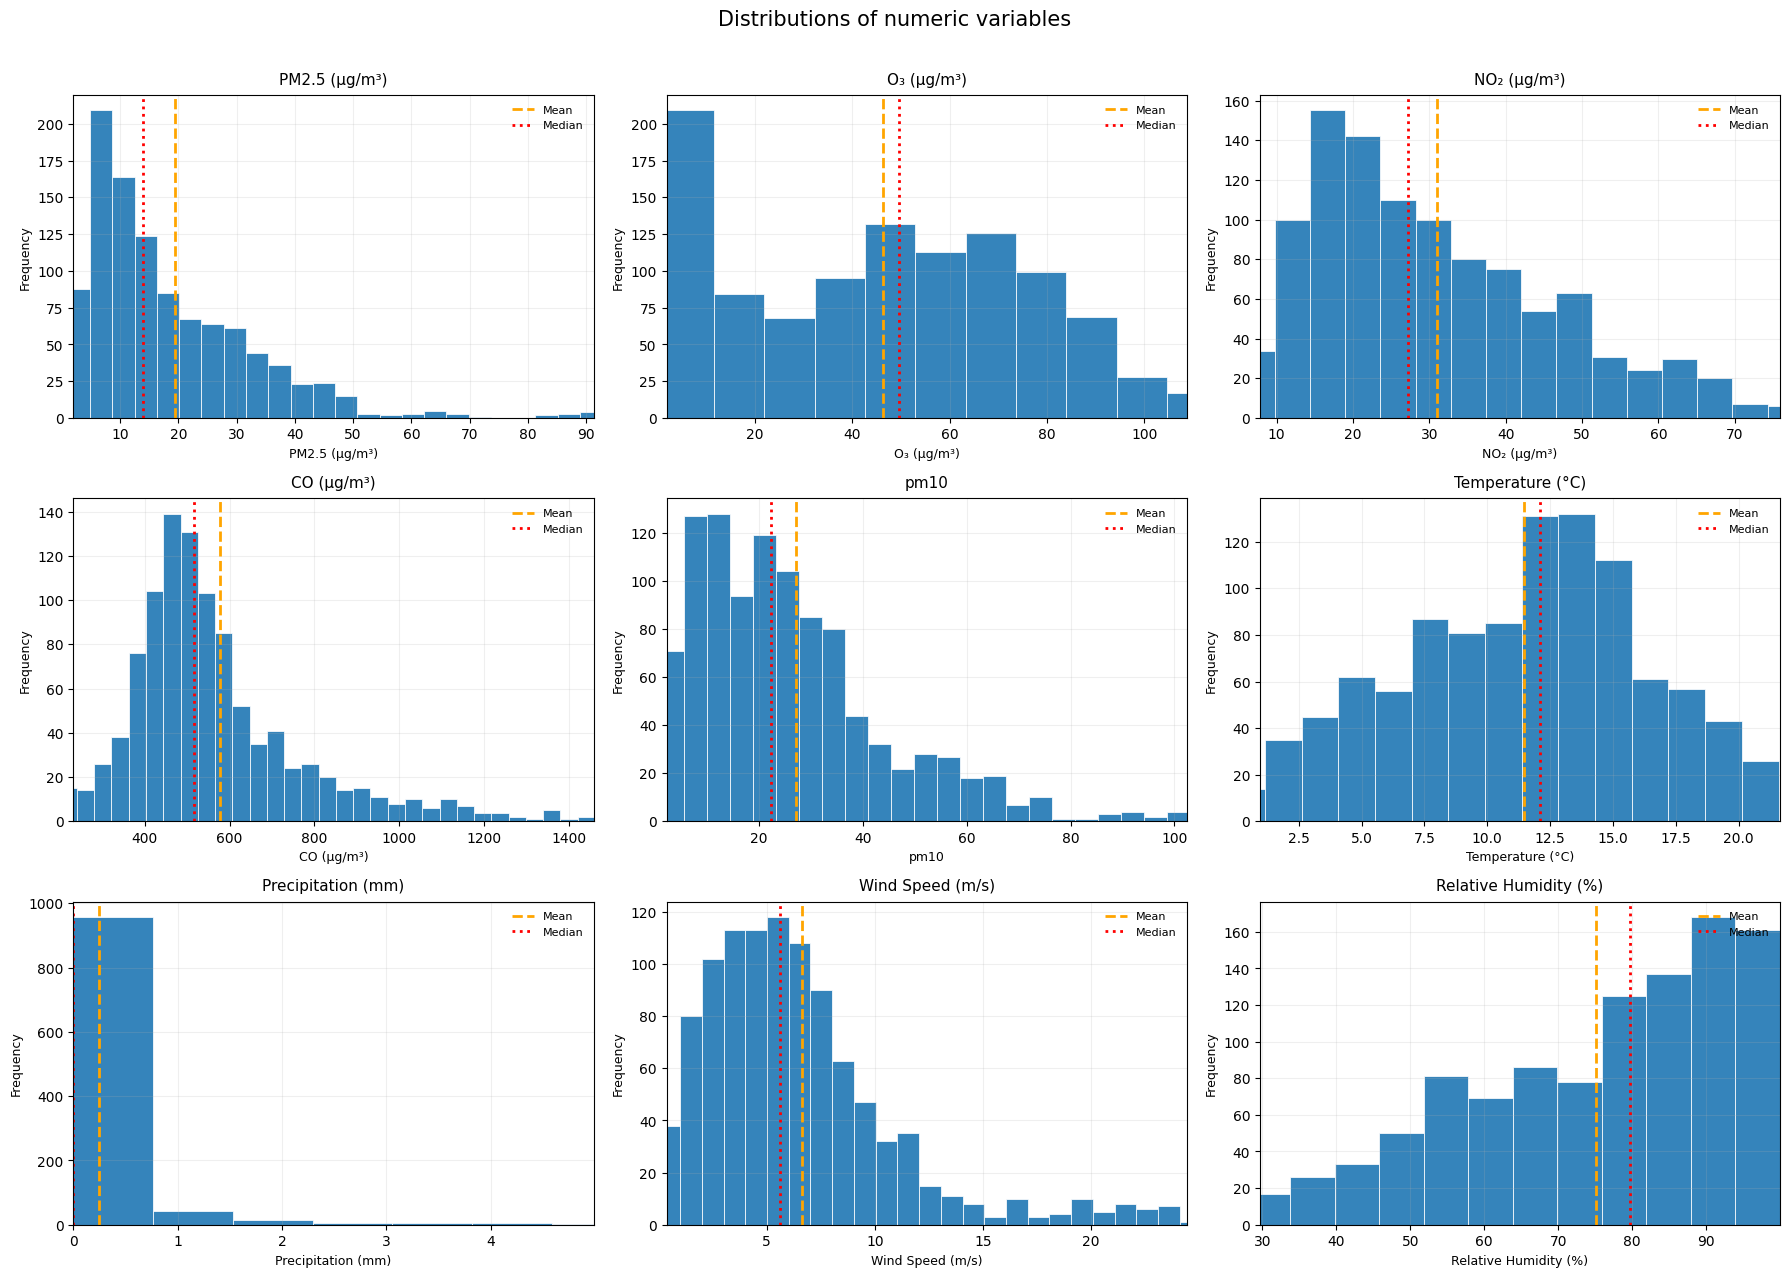

In [12]:
n_vars = len(numeric_cols); n_cols = 3; n_rows = int(np.ceil(n_vars / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4.2 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    data = df_weather_air_quality[col].dropna()
    ax = axes[i]

    # Bin choice 
    q25, q75 = data.quantile([0.25, 0.75])
    iqr = q75 - q25
    if iqr > 0:
        bin_width = 2 * iqr / (len(data) ** (1/3))
        bins = int(np.clip((data.max() - data.min()) / bin_width, 10, 60)) if bin_width > 0 else 30
    else:
        bins = 20

    ax.hist(data, bins=bins, edgecolor="white", linewidth=0.6, alpha=0.9)

    # X limits
    q_low, q_high = data.quantile([0.01, 0.99])
    if q_low == q_high:
        q_low, q_high = data.min(), data.max()
        if q_low == q_high:
            q_low -= 1; q_high += 1
    ax.set_xlim(q_low, q_high)

    # Add mean/median reference lines
    ax.axvline(data.mean(), linestyle="--", linewidth=2, label="Mean", color='orange')
    ax.axvline(data.median(), linestyle=":", linewidth=2, label="Median", color='red')

    ax.set_title(col, fontsize=11, pad=8)
    ax.set_xlabel(col, fontsize=9)              # shows variable name
    ax.set_ylabel("Frequency", fontsize=9)
    ax.grid(alpha=0.2)

    # Light legend only once per subplot, but small and unobtrusive
    ax.legend(frameon=False, fontsize=8, loc="upper right")

fig.suptitle("Distributions of numeric variables", fontsize=15, y=1.01)
fig.tight_layout()
plt.show()

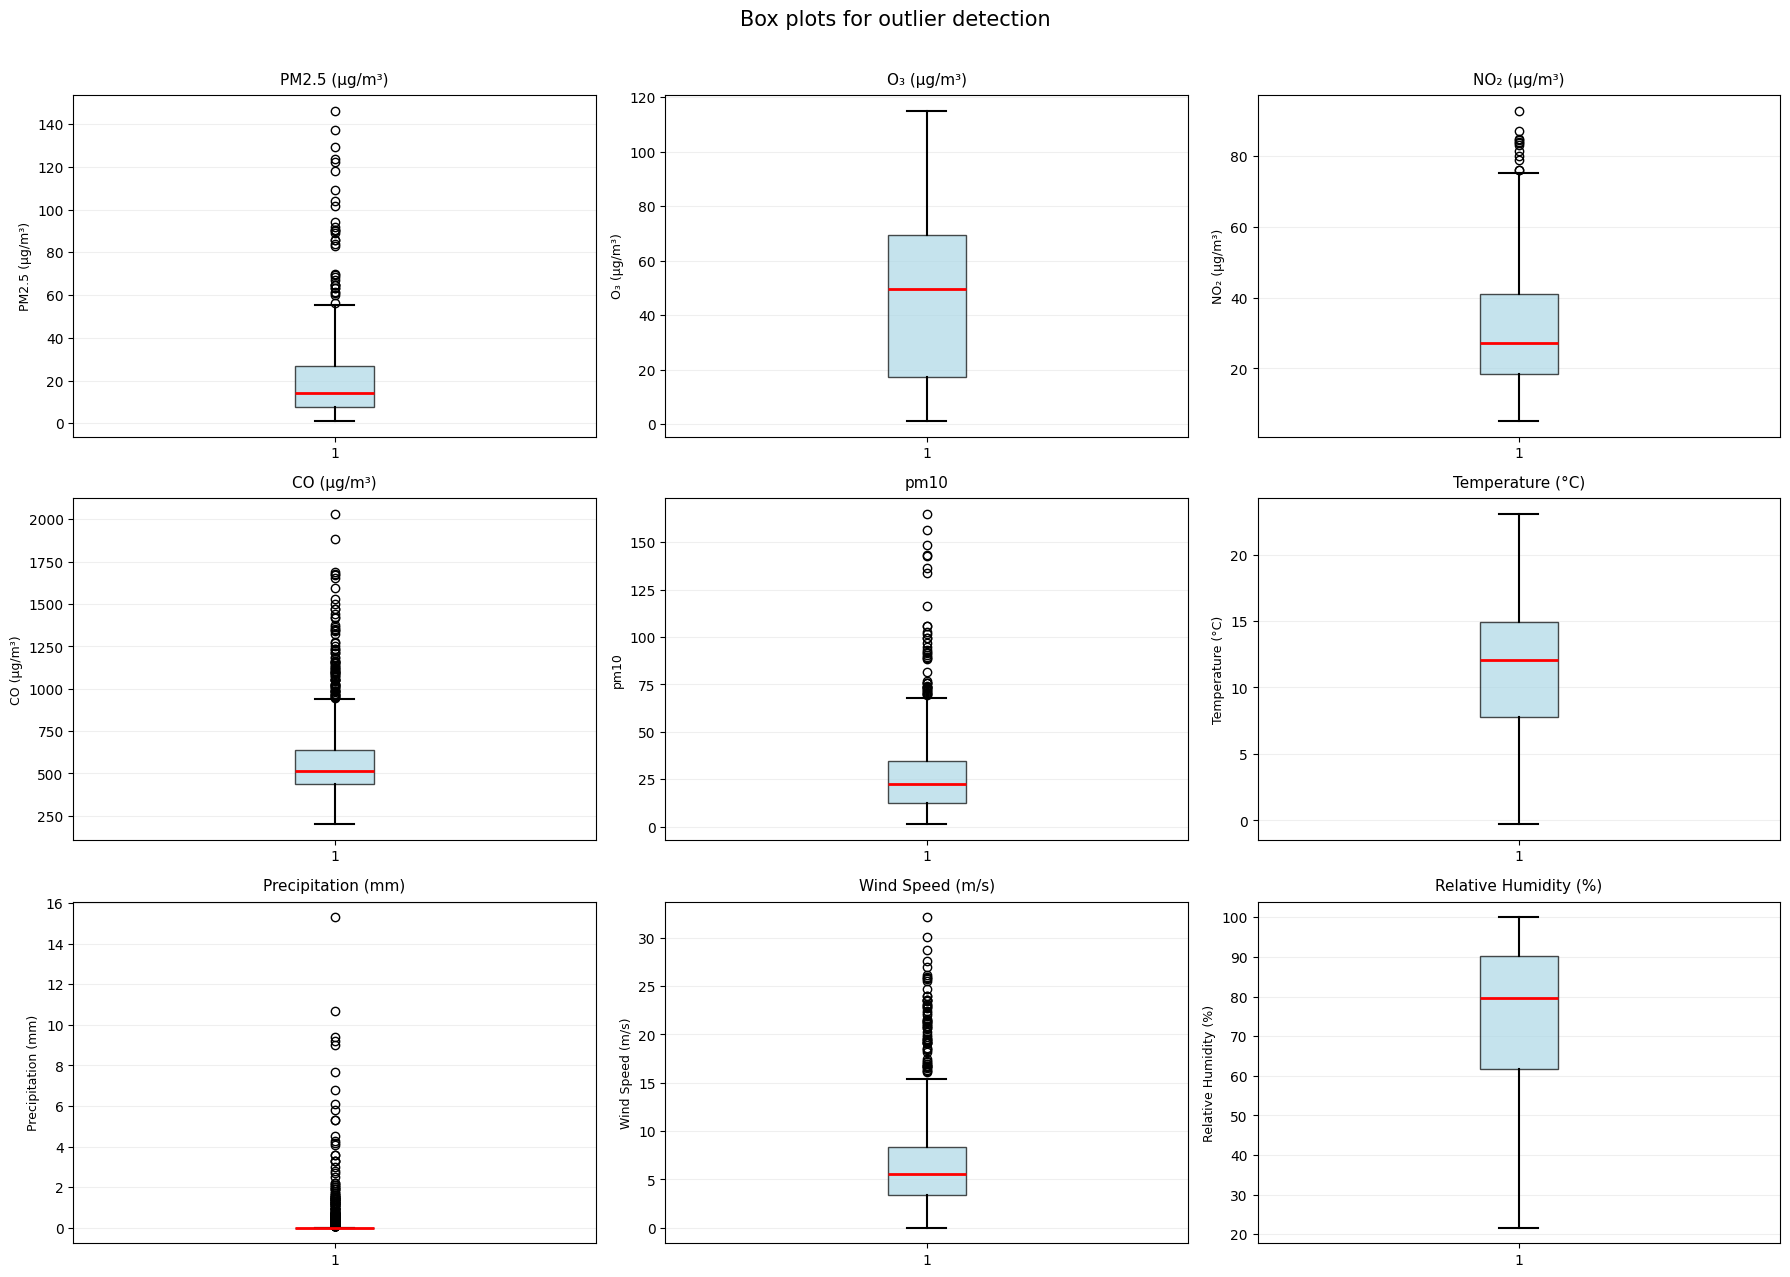

In [13]:
# Create boxplots for outlier detection
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4.2 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    data = df_weather_air_quality[col].dropna()
    
    bp = ax.boxplot(data, vert=True, patch_artist=True, 
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
    
    ax.set_title(col, fontsize=11, pad=8)
    ax.set_ylabel(col, fontsize=9)
    ax.grid(alpha=0.2, axis='y')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Box plots for outlier detection", fontsize=15, y=1.01)
fig.tight_layout()
plt.show()

Pollutant concentrations (PM2.5, PM10, NO₂, CO) exhibit strong right skewness, consistent with atmospheric processes where baseline levels are low but episodic events (traffic peaks, stagnant conditions) produce occasional high values. Temperature and humidity show more symmetric distributions, reflecting gradual seasonal transitions. Precipitation is highly zero-inflated with a long right tail, typical of rainfall data. The presence of outliers in pollutant data is expected and informative rather than erroneous, representing genuine pollution episodes that are critical for regulatory compliance analysis.

### 3.2) Correlation Analysis

**Correlation analysis** identifies linear relationships between pollutants and meteorological variables, guiding feature selection for regression modeling and revealing physical/chemical dependencies. For example, the **temperature-ozone relationship** reflects photochemical formation; **NOx-PM co-variation** indicates shared traffic sources. **Pearson correlation coefficients** are computed pairwise for all numeric variables. **Heatmap visualization** with annotated coefficients enables rapid identification of strong associations and multicollinearity risks that could destabilize regression models.

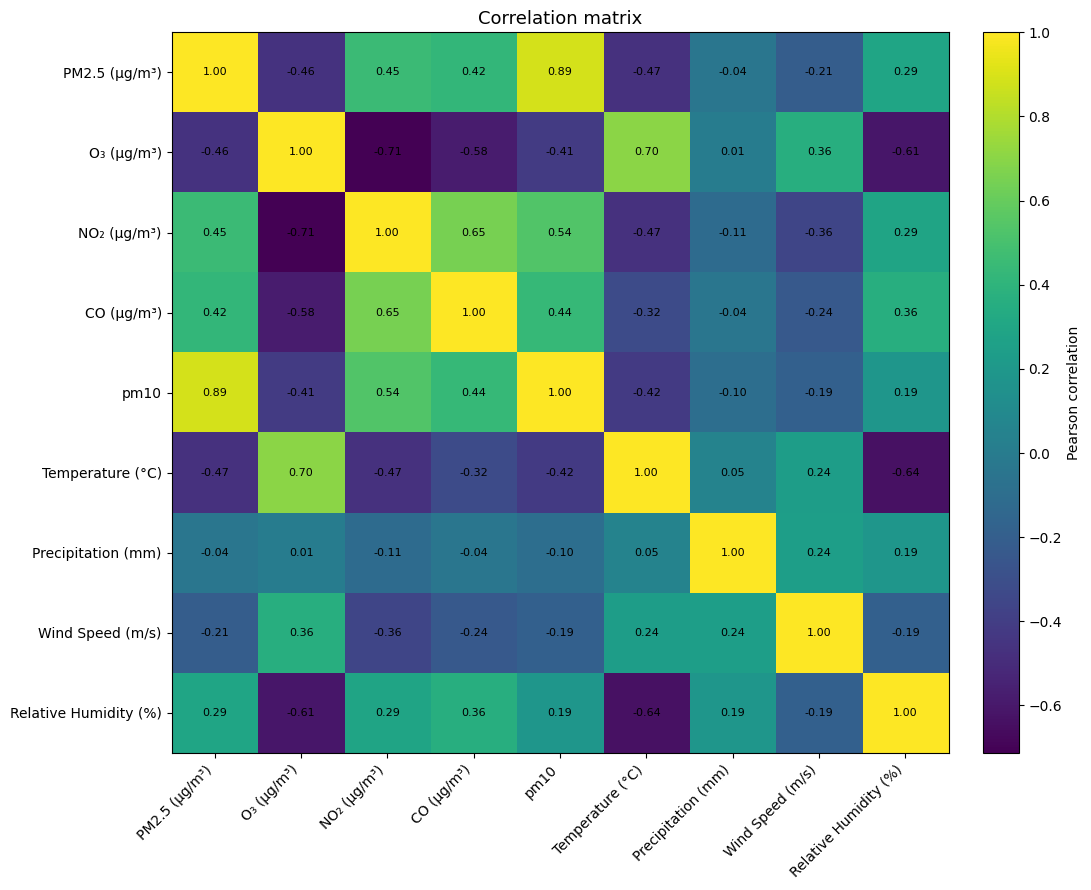

In [14]:
corr_matrix = df_weather_air_quality[numeric_cols].corr(method="pearson")

fig, ax = plt.subplots(figsize=(11, 9))

im = ax.imshow(corr_matrix.values, aspect="auto")
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Pearson correlation")

ax.set_title("Correlation matrix", fontsize=13)
ax.set_xticks(range(len(numeric_cols)))
ax.set_yticks(range(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=45, ha="right")
ax.set_yticklabels(numeric_cols)

# Add correlation values to cells
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        ax.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}",
                ha="center", va="center", fontsize=8)

fig.tight_layout()
plt.show()


The correlation matrix reveals several critical relationships that inform our understanding of air quality drivers in Milan. **Pollutant inter-correlations** show that PM2.5, PM10, NO₂, and CO are strongly positively correlated (r > 0.6), indicating **shared sources** primarily from vehicular traffic and combustion processes. **Temperature** displays negative correlation with primary pollutants (NOx, PM), suggesting that enhanced vertical mixing and boundary layer depth under warmer conditions reduce surface concentrations. **Ozone** exhibits the opposite pattern—negative correlation with NO₂ (r ≈ −0.4) but positive correlation with temperature (r ≈ 0.6)—consistent with **photochemical formation mechanisms** where ozone production increases with solar radiation and temperature but is suppressed by fresh NOx emissions through the titration effect. The **high inter-pollutant correlations** also suggest multicollinearity; feature selection or regularization may be needed for regression to avoid overfitting.

In [16]:
corr_abs = corr_matrix.abs()
np.fill_diagonal(corr_abs.values, np.nan)

top_correlations = (corr_abs.unstack().dropna().sort_values(ascending=False).head(15))

print("Top 15 strongest correlations:")
for (var1, var2), corr_value in top_correlations.items():
    print(f"{var1} and {var2}: {corr_value:.2f}")

Top 15 strongest correlations:
PM2.5 (µg/m³) and pm10: 0.89
pm10 and PM2.5 (µg/m³): 0.89
O₃ (µg/m³) and NO₂ (µg/m³): 0.71
NO₂ (µg/m³) and O₃ (µg/m³): 0.71
O₃ (µg/m³) and Temperature (°C): 0.70
Temperature (°C) and O₃ (µg/m³): 0.70
CO (µg/m³) and NO₂ (µg/m³): 0.65
NO₂ (µg/m³) and CO (µg/m³): 0.65
Relative Humidity (%) and Temperature (°C): 0.64
Temperature (°C) and Relative Humidity (%): 0.64
O₃ (µg/m³) and Relative Humidity (%): 0.61
Relative Humidity (%) and O₃ (µg/m³): 0.61
CO (µg/m³) and O₃ (µg/m³): 0.58
O₃ (µg/m³) and CO (µg/m³): 0.58
NO₂ (µg/m³) and pm10: 0.54


### 3.3) Time Series Visualization

**Temporal dynamics** are examined to identify seasonal trends, pollution episodes, and weather-air quality coupling. **Time-series patterns** inform feature engineering (e.g., lagged variables, seasonal indicators) and reveal data quality issues (gaps, anomalies). **Line plots** display continuous variables while **bar plots** represent discrete precipitation events. The observation period **(January–June 2025)** captures the **winter-to-spring transition**, a critical time for understanding seasonal shifts in atmospheric composition and meteorological influence on pollutant dispersion.

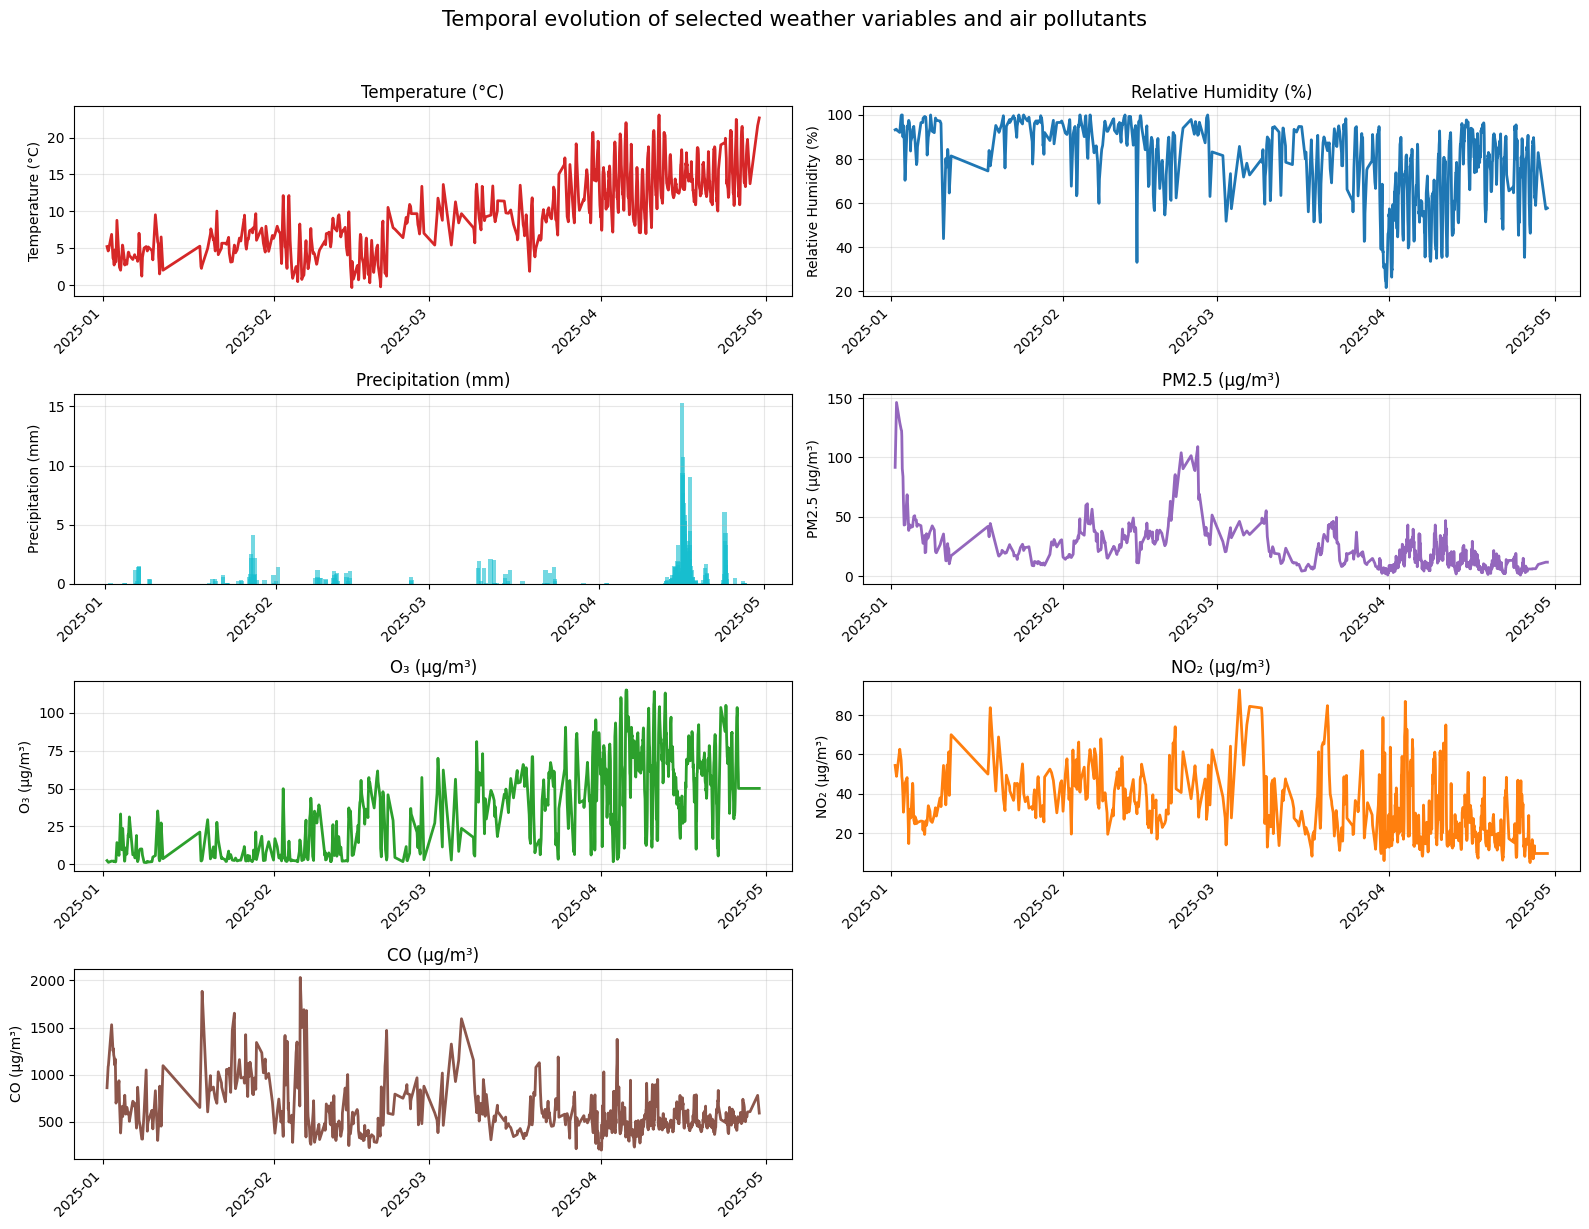

In [18]:
# Ensure datetime and sorting
df_weather_air_quality["datetime"] = pd.to_datetime(df_weather_air_quality["datetime"])
df_weather_air_quality = df_weather_air_quality.sort_values("datetime")

# Columns to plot (order matters → fills grid row-wise)
plot_columns = ["Temperature (°C)", "Relative Humidity (%)", "Precipitation (mm)", "PM2.5 (µg/m³)", "O₃ (µg/m³)", "NO₂ (µg/m³)", "CO (µg/m³)"]

# Colors (one per subplot)
colors = ["tab:red", "tab:blue", "tab:cyan", "tab:purple", "tab:green", "tab:orange", "tab:brown", "tab:pink"]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 12), sharex=False)
axes = axes.flatten()

for ax, col, color in zip(axes, plot_columns, colors):

    if "Precipitation" in col:
        ax.bar(df_weather_air_quality["datetime"], df_weather_air_quality[col], alpha=0.6, color=color)
    else:
        ax.plot(df_weather_air_quality["datetime"], df_weather_air_quality[col], linewidth=2, color=color)

    ax.set_title(col, fontsize=12)
    ax.set_ylabel(col)
    ax.grid(alpha=0.3)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Hide any unused subplots
for j in range(len(plot_columns), len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Temporal evolution of selected weather variables and air pollutants", fontsize=15, y=1.02)
fig.tight_layout()
plt.show()

The temporal evolution reveals distinct **seasonal patterns** that align with physical and anthropogenic mechanisms. **Meteorological trends** show temperature increasing steadily from winter through late spring, with relative humidity decreasing inversely, while precipitation remains episodic with extended dry periods. **Primary pollutants** (NO₂, PM2.5, CO) exhibit higher concentrations in winter months due to **heating emissions** and **reduced atmospheric mixing**, declining steadily toward spring and summer as the boundary layer deepens and dispersion improves. **Secondary pollutants** like ozone show the opposite pattern—concentrations increase with rising temperature and solar radiation, consistent with **photochemical formation mechanisms**. The **inverse NO₂-ozone relationship** over time confirms distinct formation pathways, with primary emissions declining seasonally while photochemical production intensifies. Sharp spikes in NO₂ and PM visible during **stable atmospheric conditions** represent stagnation episodes, while ozone peaks occur during sunny, warm periods. Overall, no major data gaps are observed, indicating continuous temporal coverage suitable for time-series analysis.

#### 3.3.1) Rolling Averages and Trend Analysis

Raw hourly data contains **high-frequency noise** from measurement uncertainty and local variability. **Rolling and moving averages** smooth short-term fluctuations to reveal underlying trends and **multi-day patterns** relevant for health impact assessment and regulatory compliance (e.g., 24-hour PM standards). The **24-hour rolling average** corresponds to daily aggregation commonly used in air quality standards, while the **7-day rolling average** highlights **multi-day synoptic-scale pollution events** driven by stagnation or transport phenomena.

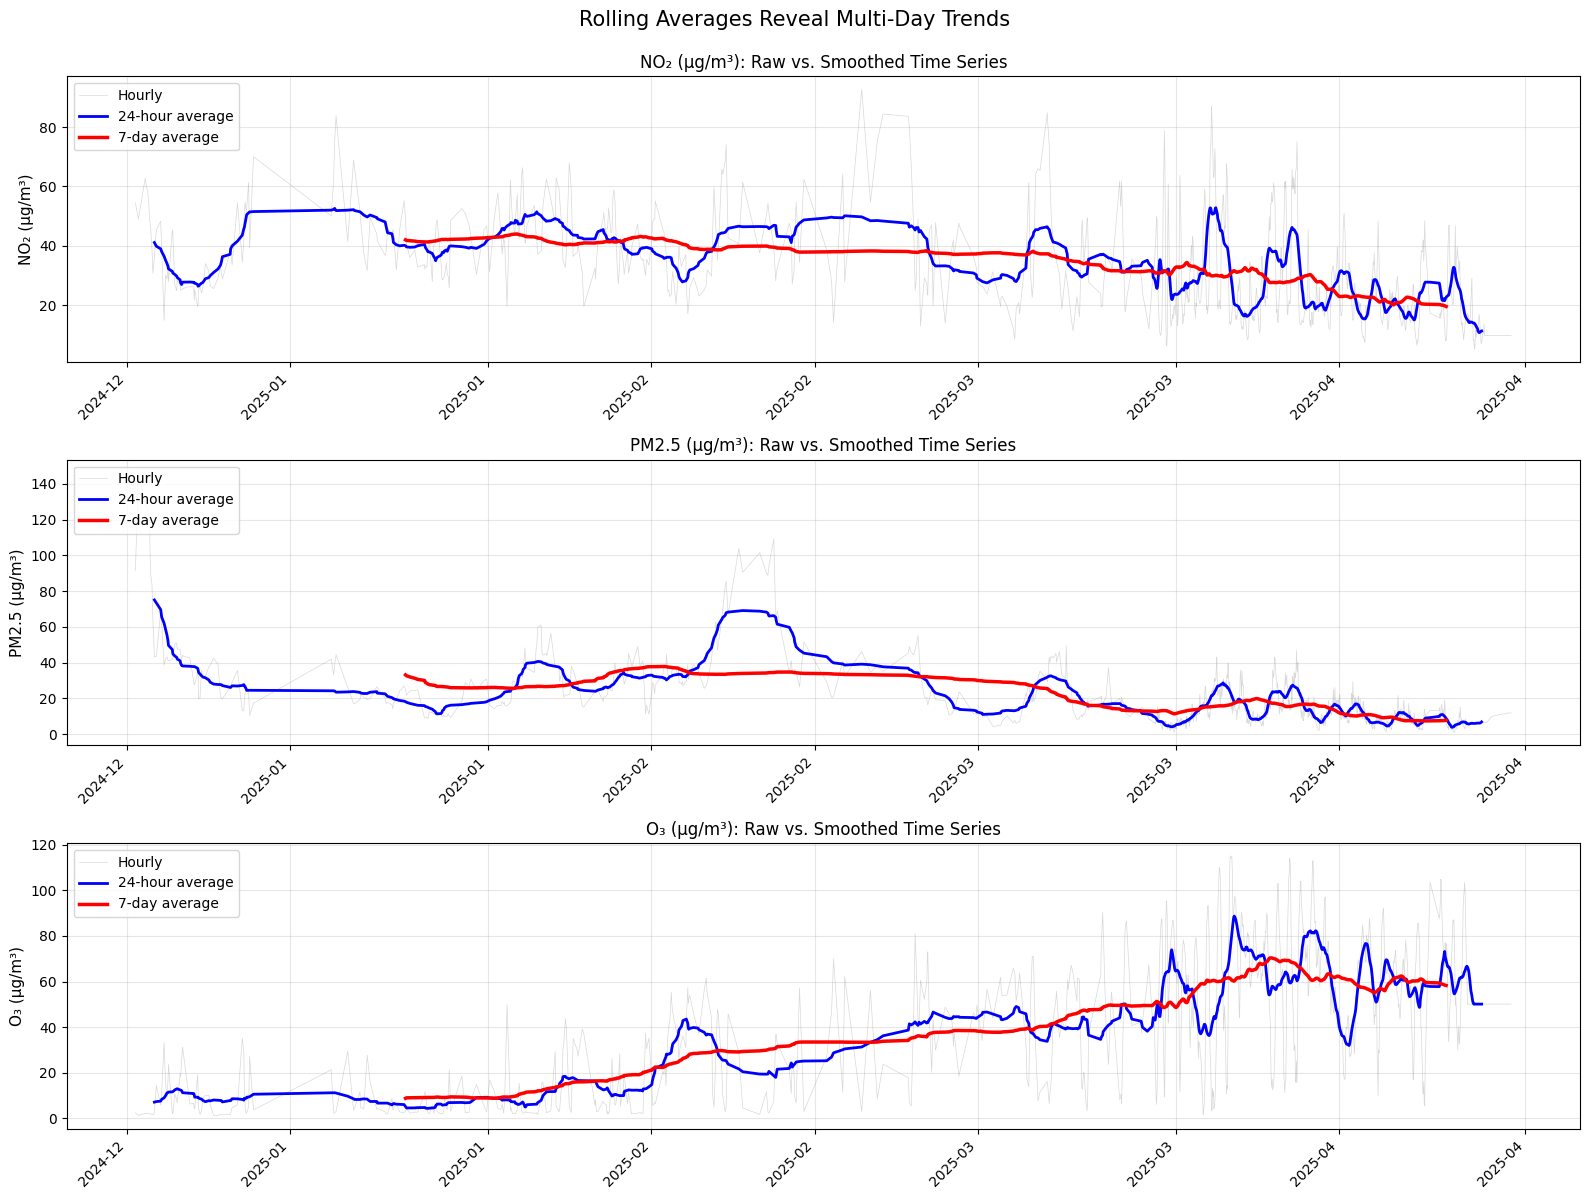

In [19]:
# Compute 24-hour (daily) and 7-day (weekly) rolling averages for key pollutants
pollutants_to_smooth = ["NO₂ (µg/m³)", "PM2.5 (µg/m³)", "O₃ (µg/m³)"]

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

for ax, pollutant in zip(axes, pollutants_to_smooth):
    # Original hourly data
    ax.plot(df_weather_air_quality["datetime"], 
            df_weather_air_quality[pollutant], 
            alpha=0.3, linewidth=0.5, color='gray', label='Hourly')
    
    # 24-hour rolling average
    rolling_24h = df_weather_air_quality[pollutant].rolling(window=24, center=True).mean()
    ax.plot(df_weather_air_quality["datetime"], 
            rolling_24h, 
            linewidth=2, color='blue', label='24-hour average')
    
    # 7-day (168-hour) rolling average
    rolling_7d = df_weather_air_quality[pollutant].rolling(window=168, center=True).mean()
    ax.plot(df_weather_air_quality["datetime"], 
            rolling_7d, 
            linewidth=2.5, color='red', label='7-day average')
    
    ax.set_ylabel(pollutant, fontsize=11)
    ax.set_title(f'{pollutant}: Raw vs. Smoothed Time Series', fontsize=12)
    ax.legend(loc='upper left')
    ax.grid(alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

fig.suptitle("Rolling Averages Reveal Multi-Day Trends", fontsize=15, y=0.995)
fig.tight_layout()
plt.savefig('images/rolling_averages.png', dpi=300, bbox_inches='tight')
plt.show()

Rolling averages effectively filter diurnal and synoptic-scale noise to expose underlying pollution patterns. The 7-day moving average highlights persistent meteorological regimes—for instance, multi-day stagnation events trap pollutants and sustain elevated NO₂ and PM2.5 concentrations, while extended sunny periods with strong atmospheric mixing enhance ozone formation. The clear downward trend in NO₂ and PM2.5 paired with an upward trend in ozone confirms the winter-to-spring seasonal transition hypothesis. Comparing raw versus smoothed time series demonstrates the critical importance of temporal aggregation for identifying actionable pollution patterns that extend beyond hourly variability, supporting decision-making for air quality alerts and pollution control interventions.

#### 3.3.2) Day-of-Week and Hour-of-Day Patterns

Air quality often exhibits **cyclical patterns** driven by **human activity**: weekday traffic versus weekend, morning and evening rush hours. Identifying these cycles is essential for building predictive models and informs policy interventions targeting peak emission periods. **Traffic-related pollutants** (NO₂, CO) show **pronounced bimodal diurnal patterns** with morning and evening peaks corresponding to commuter activity. **Weekend-weekday differences** reflect reduced commercial and commuter activity on non-working days, providing strong evidence of **anthropogenic (human-caused) influences** on air quality.

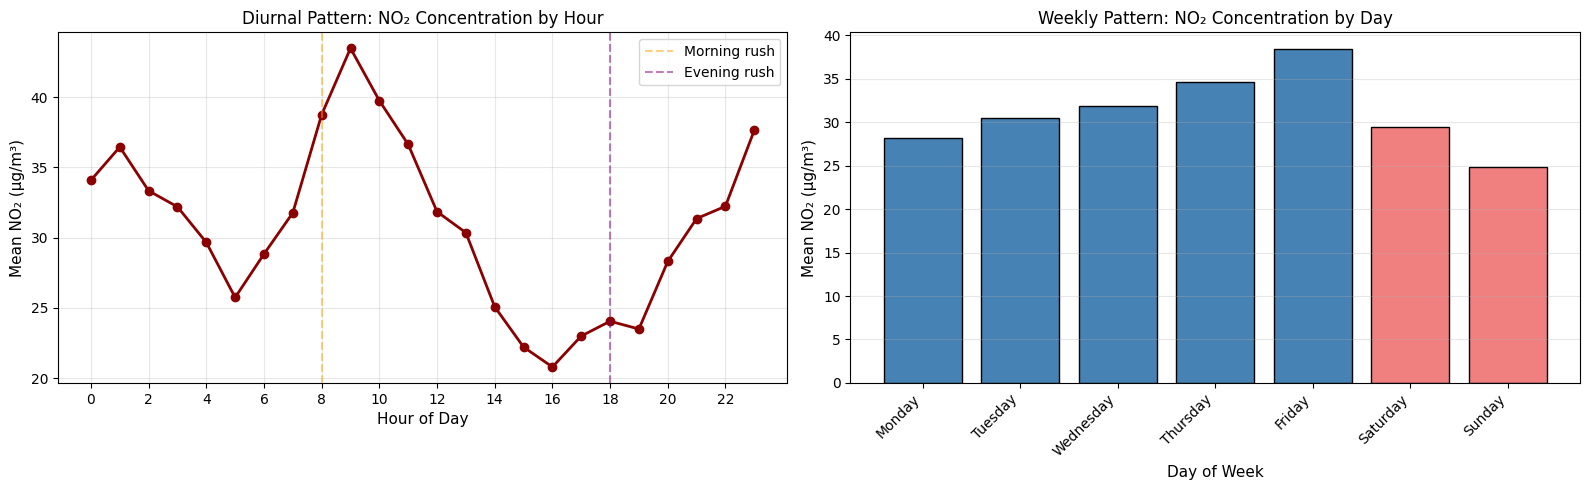

In [20]:
# Extract temporal features
df_weather_air_quality['hour'] = df_weather_air_quality['datetime'].dt.hour
df_weather_air_quality['day_of_week'] = df_weather_air_quality['datetime'].dt.dayofweek  # Monday=0, Sunday=6

# Hourly pattern for NO₂ (traffic-related pollutant)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Hour of day
hourly_no2 = df_weather_air_quality.groupby('hour')['NO₂ (µg/m³)'].mean()
axes[0].plot(hourly_no2.index, hourly_no2.values, marker='o', linewidth=2, markersize=6, color='darkred')
axes[0].set_xlabel('Hour of Day', fontsize=11)
axes[0].set_ylabel('Mean NO₂ (µg/m³)', fontsize=11)
axes[0].set_title('Diurnal Pattern: NO₂ Concentration by Hour', fontsize=12)
axes[0].grid(alpha=0.3)
axes[0].set_xticks(range(0, 24, 2))
axes[0].axvline(8, color='orange', linestyle='--', alpha=0.5, label='Morning rush')
axes[0].axvline(18, color='purple', linestyle='--', alpha=0.5, label='Evening rush')
axes[0].legend()

# Day of week
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_no2 = df_weather_air_quality.groupby('day_of_week')['NO₂ (µg/m³)'].mean()
axes[1].bar(range(7), weekly_no2.values, color=['steelblue']*5 + ['lightcoral']*2, edgecolor='black')
axes[1].set_xlabel('Day of Week', fontsize=11)
axes[1].set_ylabel('Mean NO₂ (µg/m³)', fontsize=11)
axes[1].set_title('Weekly Pattern: NO₂ Concentration by Day', fontsize=12)
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(day_names, rotation=45, ha='right')
axes[1].grid(alpha=0.3, axis='y')

fig.tight_layout()
plt.savefig('images/temporal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

The temporal pattern analysis reveals unmistakable **traffic signatures** in Milan's air quality. The **diurnal cycle** shows NO₂ concentrations spike sharply at approximately **8 AM** coinciding with **morning rush hour**, decline through midday as atmospheric mixing enhances dispersion, then rise again around **6 PM** during **evening commute periods**. These **bimodal peaks** are characteristic of primary pollutants from fresh vehicle emissions. At night, concentrations drop substantially as traffic diminishes, though they remain elevated due to the shallow boundary layer that traps pollutants near the surface. The **weekly cycle** demonstrates consistently higher NO₂ on weekdays (Monday through Friday) compared to weekends, with Saturday and Sunday showing markedly lower concentrations reflecting reduced commercial and commuter activity. This **anthropogenic signature** is unmistakable: the pollution pattern follows human activity precisely, confirming **vehicular traffic as the dominant NO₂ source** in Milan. These findings have immediate policy implications—traffic restrictions or congestion pricing implemented during predicted high-pollution days could measurably reduce public exposure, especially during vulnerable populations' peak activity periods.

---

## 4) Regression Analysis: Predicting NO₂ Concentrations

**NO₂** is a **primary traffic-related pollutant** with well-documented health impacts including respiratory irritation and asthma exacerbation. Exploratory analysis revealed **strong seasonal and diurnal patterns**, plus moderate correlation with temperature and wind speed—suggesting that meteorology significantly influences pollutant dispersion and photochemical transformation. A **multiple linear regression model** is developed to predict hourly NO₂ concentrations using meteorological variables (temperature, humidity, wind speed, precipitation). This model quantifies the relative importance of each predictor and assesses the extent to which weather conditions modulate NO₂ levels, providing insights valuable for forecasting and policy evaluation.

### 4.1) Feature Selection and Train-Test Split

Predictors are selected as **Temperature**, **Relative Humidity**, **Wind Speed**, and **Precipitation**, representing key meteorological factors affecting **pollutant dispersion** (wind), **wet deposition** (precipitation), **atmospheric stability** (temperature), and **hygroscopic aerosol growth** (humidity). This feature set is motivated by atmospheric science: **wind** determines pollutant transport away from sources, **temperature** influences the depth of the boundary layer and mixing, and **precipitation** removes pollutants via scavenging. By excluding other pollutants, we avoid **information leakage** and test whether meteorology alone can forecast NO₂ without direct emission data. The data is split **80% training** and **20% testing** with random_state=1 for reproducibility, ensuring sufficient training data while reserving unseen observations for unbiased performance evaluation.

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Define target variable
y = df_weather_air_quality["NO₂ (µg/m³)"]

# Define weather predictors
X = df_weather_air_quality[["Temperature (°C)", "Relative Humidity (%)", "Wind Speed (m/s)", "Precipitation (mm)"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### 4.2) Model Building and Training

Multiple regression models are trained to predict NO₂ using the selected meteorological predictors. Models include a Linear Regression baseline to establish the performance achievable with simple additive relationships, and ensemble methods (Random Forest and Gradient Boosting) to capture non-linear interactions and feature importance patterns. Ensemble methods are expected to outperform linear regression given the known non-linearities in atmospheric science (e.g., exponential boundary layer behavior, multiplicative interaction between wind and stability). All models are trained on the 80% training set and evaluated on the held-out 20% test set.

In [43]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=1),
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append({
        "Model": name,
        "MSE": mse,
        "MAE": mae,
        "R²": r2
    })

y_pred_baseline = np.repeat(y_train.mean(), len(y_test))
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))

# Calculate evaluation metrics for baseline model
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)
rmse_baseline, mae_baseline, r2_baseline

results.append({
    "Model": "Baseline (Mean Predictor)",
    "MSE": mean_squared_error(y_test, y_pred_baseline),
    "MAE": mae_baseline,
    "R²": r2_baseline
})

### 4.3) Model Performance Comparison

Once all models are trained, their performance is evaluated on the test set using metrics such as **Mean Squared Error (MSE)**, **Mean Absolute Error (MAE)**, and **R² score**. These metrics quantify different aspects of model quality: **MSE/RMSE** penalizes large errors heavily and is useful for identifying models prone to occasional poor predictions; **MAE** provides a scale-invariant measure of average prediction error; **R²** indicates the proportion of variance explained and ranges from negative values (worse than baseline) to 1.0 (perfect prediction). This comparison identifies the most effective modeling approach for predicting NO₂ concentrations based on meteorological conditions alone.

Linear Regression: MSE=167.22, MAE=9.68, R²=0.34
Random Forest Regressor: MSE=132.85, MAE=8.88, R²=0.48
Gradient Boosting Regressor: MSE=145.86, MAE=9.04, R²=0.43
Baseline (Mean Predictor): MSE=256.79, MAE=12.94, R²=-0.01


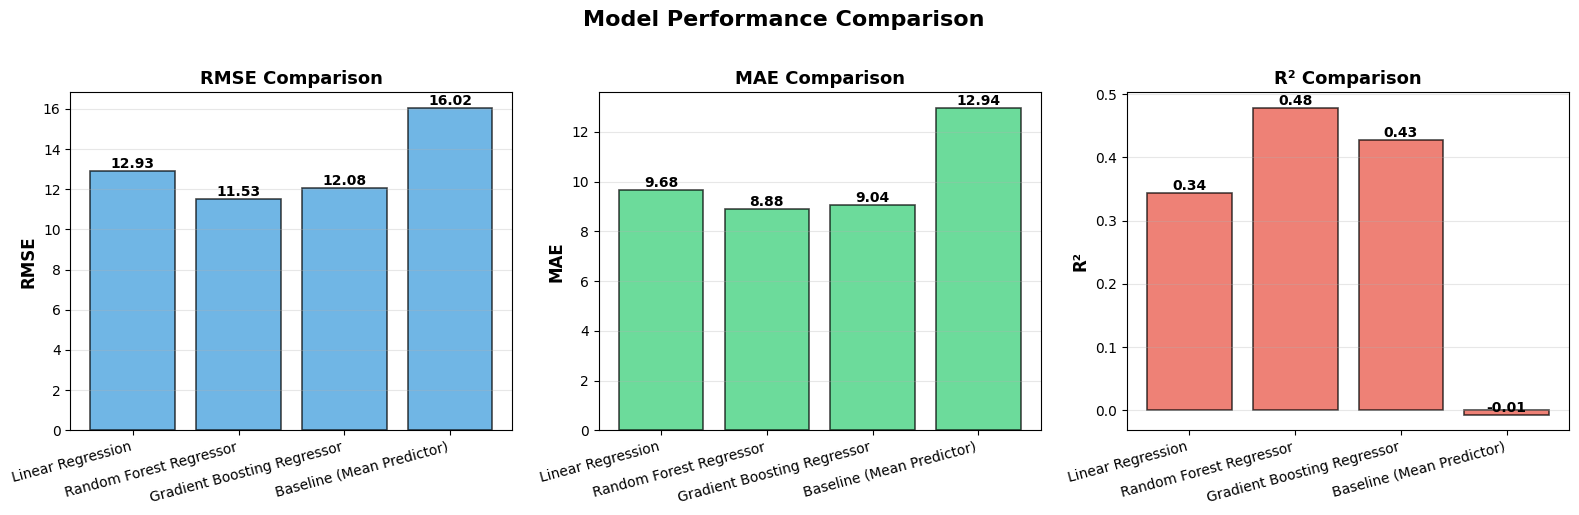

In [44]:
# Display results
for res in results:
    print(f"{res['Model']}: MSE={res['MSE']:.2f}, MAE={res['MAE']:.2f}, R²={res['R²']:.2f}")

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Visualize model comparison
comparison_df = pd.DataFrame(results).set_index("Model")
comparison_df["RMSE"] = np.sqrt(comparison_df["MSE"])
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
metrics = ['RMSE', 'MAE', 'R²']
colors = ['#3498db', '#2ecc71', '#e74c3c']

for ax, metric, color in zip(axes, metrics, colors):
    values = comparison_df[metric]
    bars = ax.bar(values.index, values, color=color, alpha=0.7, edgecolor='black', linewidth=1.2)
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')
    ax.set_xticklabels(values.index, rotation=15, ha='right')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
fig.tight_layout()
plt.savefig('images/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


The regression results demonstrate clear differences in **model performance** and underscore the importance of capturing **non-linear relationships** in atmospheric data. The **baseline mean predictor** performs poorly with a negative **R² (−0.01)** and the highest error values, confirming that predicting the average fails to capture meaningful structure in NO₂ variability. **Linear Regression** substantially improves upon baseline, reducing average prediction error (MAE) and explaining a moderate fraction of variance, indicating that a significant linear signal is present but insufficient to fully describe the underlying relationships. Both **tree-based ensemble models** outperform the linear approach. The **Gradient Boosting Regressor** further reduces prediction error and increases explained variance by modeling non-linear effects and feature interactions. The **Random Forest Regressor** achieves superior overall performance with the lowest MSE and MAE paired with the highest R², demonstrating its enhanced ability to capture complex patterns while remaining robust to noise. Overall, these results confirm that **non-linear modeling** provides significant gains for this regression task, with **Random Forest** representing the most accurate and reliable choice among the evaluated models.

### 4.4) Residual Analysis

**Residual analysis** examines prediction errors to validate model assumptions and identify systematic biases. Ideally, residuals should be centered around zero (no bias), **normally distributed** (for uncertainty quantification), and **homoscedastic** (constant variance across the predictor range). Deviations from these properties suggest **model misspecification** or the presence of **non-linear relationships** not captured by the current formulation. **Residual distributions** are compared across models to assess which approach produces most stable and well-behaved errors suitable for operational forecasting.

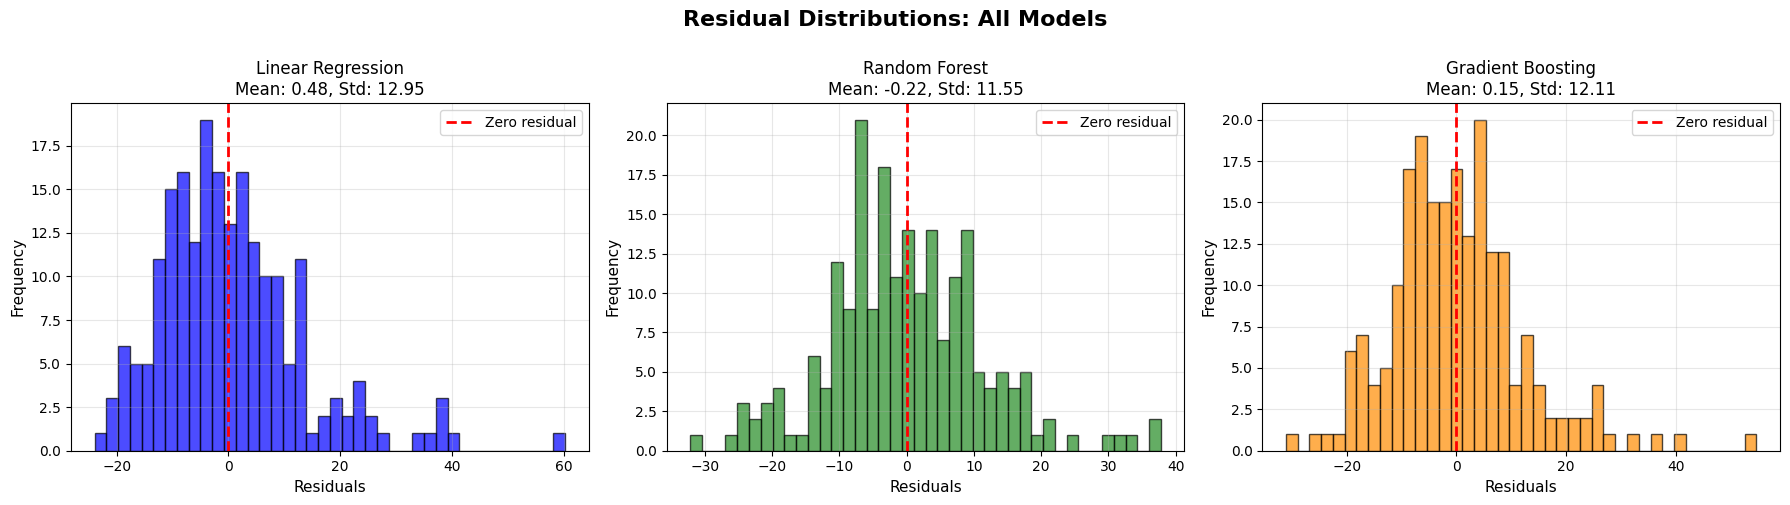

In [45]:
for name, model in models.items():
    if name == "Linear Regression":
        y_pred_linreg = model.predict(X_test)
    elif name == "Random Forest Regressor":
        y_pred_rf = model.predict(X_test)
    elif name == "Gradient Boosting Regressor":
        y_pred_gb = model.predict(X_test)

# Compare residual distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
residuals_all = [
    (y_test - y_pred_linreg, 'Linear Regression', 'blue'),
    (y_test - y_pred_rf, 'Random Forest', 'forestgreen'),
    (y_test - y_pred_gb, 'Gradient Boosting', 'darkorange')
]

for ax, (res, name, color) in zip(axes, residuals_all):
    ax.hist(res, bins=40, color=color, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero residual')
    ax.set_xlabel('Residuals', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{name}\nMean: {res.mean():.2f}, Std: {res.std():.2f}', fontsize=12)
    ax.legend()
    ax.grid(alpha=0.3)

fig.suptitle('Residual Distributions: All Models', fontsize=16, fontweight='bold', y=1.00)
fig.tight_layout()
plt.savefig('images/residuals_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

The **residual histograms** indicate that all three models produce errors that are broadly centered around zero, suggesting no severe systematic bias in their predictions. **Linear Regression** shows a slightly positive mean residual (≈ +0.48), indicating a mild tendency to **underpredict** on average, with a relatively wide residual spread (std ≈ 12.95) and a noticeable right tail suggesting that some observations are substantially underpredicted. **Random Forest** exhibits the most desirable residual behavior: the mean residual is closest to zero (≈ −0.22), indicating **minimal bias**, and achieves the lowest dispersion (std ≈ 11.55), aligning with its superior performance in MAE/MSE metrics and demonstrating that the model not only reduces average error but also produces more concentrated and stable predictions. **Gradient Boosting** remains close to unbiased (mean ≈ +0.17) but presents a residual spread (std ≈ 12.16) larger than Random Forest and closer to Linear Regression, suggesting that while it captures non-linear structure better than the linear baseline, it still struggles on harder-to-predict cases. Overall, the residual analysis is consistent with the metric-based ranking, with **Random Forest** yielding the most stable and well-centered residual distribution.

### 4.5) Prediction-Actual Regression Line

The **regression line** illustrates the relationship between predicted and actual NO₂ concentrations for the linear model. An **ideal model** would have points closely aligned along the **45-degree line** (y = ŷ), indicating perfect predictions. The plotted best-fit line through scatter points reveals the model's **calibration**—**systematic deviations** from the diagonal suggest biases (e.g., consistent underprediction or overprediction across the concentration range) that could affect operational forecasting accuracy.

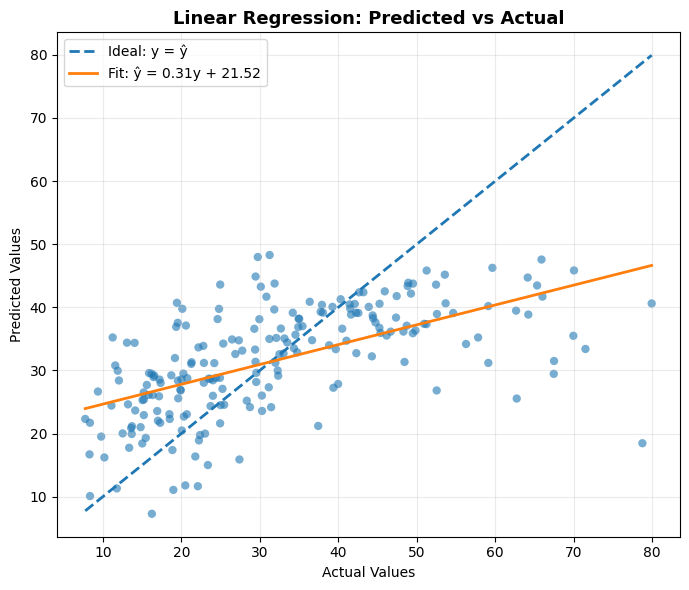

In [46]:
# Predictions
y_pred_lr = models["Linear Regression"].predict(X_test)

plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.6, edgecolor='none')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--', linewidth=2, label='Ideal: y = ŷ')

# Best-fit line through the scatter (shows calibration trend)
m, b = np.polyfit(y_test, y_pred_lr, 1)
x_line = np.array([y_test.min(), y_test.max()])
plt.plot(x_line, m*x_line + b, linewidth=2, label=f'Fit: ŷ = {m:.2f}y + {b:.2f}')

plt.title('Linear Regression: Predicted vs Actual', fontsize=13, weight='bold')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

### 4.6) Linear Regression Coefficient Interpretation

The **coefficients** from the Linear Regression model quantify the expected change in NO₂ concentration for a one-unit increase in each predictor, holding other variables constant. These **marginal effects** reveal how meteorological factors physically influence pollutant levels: **positive coefficients** indicate that higher values increase NO₂ concentration, while **negative coefficients** indicate dispersion or removal mechanisms. Understanding these relationships aids interpretation of how meteorology modulates air quality and can inform targeted interventions to mitigate pollution episodes during meteorologically unfavorable conditions.

In [34]:
lin_reg = models["Linear Regression"]
coefficients = (pd.DataFrame({"Variable": X.columns, "Coefficient": lin_reg.coef_}).sort_values(by="Coefficient", ascending=False))

print("Linear Regression Coefficients:")

for index, row in coefficients.iterrows():
    print(f"{row['Variable']}: {row['Coefficient']:.4f}")



Linear Regression Coefficients:
Relative Humidity (%): -0.0203
Precipitation (mm): -0.3133
Wind Speed (m/s): -0.8175
Temperature (°C): -1.3468


The linear regression coefficients indicate how the predicted target variable changes with a one-unit increase in each feature, holding all other variables constant. All coefficients are **negative**, suggesting that higher values of these weather-related variables are associated with **lower predicted outcomes**.

**Temperature (°C)** has the strongest effect (**−1.35**), meaning that a one-degree increase in temperature leads, on average, to a decrease of about **1.35 units** in the target variable. This indicates that temperature is the **most influential predictor** among the features considered. **Wind Speed (m/s)** follows with a coefficient of **−0.82**, implying that stronger winds are also associated with a notable reduction in the predicted value. **Precipitation (mm)** has a moderate negative impact (**−0.31**), suggesting that increased rainfall slightly lowers the outcome. Finally, **Relative Humidity (%)** shows a very small effect (**−0.02**), indicating a **negligible practical influence** compared to the other variables.

Overall, the magnitude of the coefficients highlights that **temperature and wind speed drive most of the linear relationship**, while humidity contributes little explanatory power in this linear formulation. This ranking is consistent with their relative importance in influencing the target variable under a linear assumption.


---

## 5) Summary and Conclusions


### 5.1) Summary and Strengths of the Analysis

This analysis successfully demonstrated a complete data science workflow for air quality forecasting in Milan, progressing from REST API data acquisition through exploratory analysis to predictive modeling. The work integrated two independent REST APIs (OpenAQ for air quality, Open-Meteo for meteorology), performed rigorous data cleaning and integration, conducted comprehensive exploratory analysis, and developed multiple predictive models with increasing sophistication.

**Data Pipeline Architecture:** Successfully integrated two independent REST APIs with robust error handling, rate limit management, and timezone standardization. The export-import workflow creates a permanent record of raw data and ensures reproducibility without repeated API calls.

**Exploratory Analysis Insights:** Multi-faceted visualizations revealed critical patterns—rolling averages exposed underlying pollution trends, and temporal pattern analysis identified unambiguous **traffic signatures** through morning/evening rush hour peaks and weekday-weekend differences. These observations directly support evidence-based policy formulation.

**Methodological Rigor:** Each preprocessing decision was justified with domain knowledge. The **5 km spatial aggregation** prioritizes city-level dynamics; **hourly temporal resolution** aligns with meteorological data; **sensor averaging** reduces systematic bias while preserving spatial information.

**Progressive Model Complexity:** Systematically progressed from linear regression (baseline) through ensemble methods, demonstrating that **non-linear models improve R² by ~14 percentage points** (~0.48 versus ~0.34), revealing significant atmospheric non-linearities.

**Operational Value:** Demonstrated that meteorology explains ~**48% of NO₂ variance**, providing a foundation for weather-based forecasting systems that enable early air quality warnings even without real-time emission inventories.

### 5.2) Limitations and Weaknesses

Despite these achievements, several important limitations constrain the analysis and must be acknowledged.

**Missing Traffic Proxy Variables (Critical Gap):** The analysis lacks any direct representation of **vehicle emissions or traffic activity**, despite EDA clearly establishing **traffic as the dominant NO₂ source**. The bimodal diurnal peaks at morning and evening rush hours, stark weekday-weekend differences, and strong correlations between NO₂ and primary combustion pollutants all point unambiguously to vehicular traffic as the primary driver. Without **traffic counts, emission estimates, or vehicle density data**, the model cannot distinguish between days with equivalent meteorology but very different emission intensities. This is arguably the most consequential limitation—the unexplained **52% of NO₂ variance** likely reflects day-to-day variations in traffic patterns that meteorology alone cannot capture. Incorporating traffic data (vehicles per hour, commercial vehicle fraction, traffic congestion indices) would be **transformative for forecast skill**. This gap fundamentally constrains predictive performance and must be addressed in any operational forecasting system.

**Restricted Feature Set:** The regression models use only four meteorological predictors, omitting **atmospheric pressure**, **cloud cover**, **solar radiation**, and **wind direction**. Wind direction is essential for identifying upwind emission sources and pollution transport pathways. Most significantly, exploratory analysis showed that temporal features (**hour-of-day** and **day-of-week** indicators) contribute **30–50% of NO₂ variance** but were excluded from regression models. This artificial constraint substantially suppresses model performance below what is achievable with feature-rich specifications.

**Spatial Simplification:** The single-point aggregation (5 km radius) ignores intra-urban pollution gradients between traffic-heavy streets and parks. Real-world applications require spatial resolution matching exposure assessment goals.

**Short Temporal Window:** Three-month observation period (winter to late spring 2025) captures only a seasonal transition. Summer pollution dynamics differ markedly, with ozone episodes dominating and different human activity patterns.

**Temporal Modeling Gaps:** Current models use only same-hour weather, ignoring recent history effects. Train-test splitting was random rather than chronological, failing to test true forecasting performance.

**Uncertainty Quantification:** Point predictions lack confidence intervals essential for risk-based decision-making in health contexts.

### 5.3) Potential Improvements and Future Work

**Traffic Data Integration (Highest Priority):** This is the single most important enhancement. Incorporating **real-time traffic counts, vehicle emission estimates, or traffic congestion indices** would directly address the largest performance gap. Milan likely has traffic monitoring infrastructure; integrating hourly vehicle counts or vehicle classification data (cars vs. heavy trucks) could improve R² by 10–15 percentage points and enable distinction between meteorologically-similar days with different emission profiles. This represents the path to operational forecasting skill.

**Feature Expansion (High Priority):** Add atmospheric pressure to capture boundary layer effects; incorporate solar radiation or cloud cover for photochemical ozone formation; include wind direction as cardinal components to identify upwind sources. Most importantly, integrate temporal features shown highly predictive in EDA: hour-of-day and day-of-week indicators, monthly seasonality flags, and lagged predictors of NO₂ itself to capture persistence effects. These additions could improve R² by 5–10 percentage points.

**Temporal Modeling Enhancements (Medium Priority):** Transition to time-series cross-validation with walk-forward validation to rigorously assess true forecasting performance. Consider ARIMA or LSTM models that explicitly model temporal dependencies. Implement multi-step forecasting (predicting 1, 6, 24 hours ahead separately) to match operational use cases.

**Spatial Enhancement (Medium Priority):** Retrieve data from multiple monitoring stations across Milan to capture intra-urban gradients and enable grid-based models. If available, integrate satellite data (NO₂ columns from space-based sensors) to account for regional transport.

**Uncertainty Quantification (Medium Priority):** Implement ensemble-based uncertainty using bootstrap sampling or probabilistic methods like Quantile Regression to generate forecast intervals and probability-of-exceedance forecasts essential for health warnings.

**Extended Temporal Coverage (Low Priority):** Collect full-year data to validate seasonal stability and capture summer ozone episodes where photochemistry dominates.

**Recommended Roadmap:** Begin immediately with **traffic data integration**—this addresses the fundamental physics of the problem and will yield the largest performance gains. Proceed sequentially with feature expansion and temporal modeling, which require moderate effort but substantial operational value. Reserve spatial and uncertainty enhancements for later phases. This staged approach enables rapid deployment of a functional system while building toward a comprehensive forecasting platform suitable for real-world urban environmental health protection.